In [66]:
import pandas as pd
import time
import numpy as np

# Pandas csv import is faster than python's 'with-open' technique

path_to_train_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\train.csv"
path_to_test_data = "C:\\data\\UniAdelaideAIML\\data\\assignment2\\test.csv"
train_data = pd.read_csv(path_to_train_data)
test_data = pd.read_csv(path_to_test_data)


In [67]:
def get_cols_with_missing(dfObj, value:"Missing") -> list:
    """Return list of the columns that equal the value."""
    
    listCols = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listCols.append(col)

    unique_cols = np.unique(listCols)
    return unique_cols

cols_with_missing = get_cols_with_missing(test_data, "Missing")
print(cols_with_missing)

['OverallCond' 'OverallQual' 'YearBuilt']


In [68]:
# Replace missing fields with the mean value of its column
def replace_missing_with_mean(df_object, cols_with_missing:list):
    """Replace the fields in the dataframe object with the mean of that column."""

    df_object.replace(to_replace="Missing", value=np.nan, inplace=True)

    # df_object['OverallQual'].mean() didnt' work because data type not number. Write it up in the report.
    # df_object['OverallQual'].dtypes #dtype('O') is a string

    for col in cols_with_missing:
        df_object[col] = df_object[col].astype('float') # because NaN is a float and mean() requires same data type
        df_object[col].fillna(value=df_object[col].mean(), inplace=True) 
        df_object[col] = df_object[col].astype('int') # linear regression only supports int type

replace_missing_with_mean(test_data, cols_with_missing)

In [69]:
# Find the columns with 'object' datatypes
def get_categoricals(dataframe) -> list:
    categoricals = []
    for col in dataframe.columns:
        if dataframe[col].dtypes == "object":
            categoricals.append(col)
    return categoricals

categoricals = get_categoricals(test_data)
print(categoricals)

['Street', 'HouseStyle', 'ExterQual', 'BldgType', 'LotConfig']


In [70]:
# Apply one hot encoding to categoricals.
# Source: https://medium.com/jungletronics/pandas-one-hot-encoding-ohe-eb7467dc92e8

def one_hot_encode(dataframe, categoricals:list):
    """Mutates dataframe by dropping categoricals and concatenating one hot encoding."""

    for idx, category in enumerate(categoricals):
        # print(f'index: {idx} \n')
        variables_list = dataframe[category].unique()
        print(f'category: {category}: {variables_list}')
        if len(variables_list) == 2:
            set_arg = True # set drop_first true because categories are binary
        else:
            set_arg = False

        dummy1 = pd.get_dummies(dataframe[category], drop_first=set_arg)
        dataframe = pd.concat([dataframe, dummy1], axis=1).drop(category, axis=1)
    return dataframe

test_data = one_hot_encode(test_data, categoricals + ['MSSubClass'])


category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' 'SLvl' '1Story' '1.5Fin' '2.5Unf' 'SFoyer' '2.5Fin' '1.5Unf']
category: ExterQual: ['TA' 'Gd' 'Ex' 'Fa']
category: BldgType: ['1Fam' 'TwnhsE' '2fmCon' 'Twnhs' 'Duplex']
category: LotConfig: ['Corner' 'CulDSac' 'Inside' 'FR2' 'FR3']
category: MSSubClass: [ 70  60  80  20 160  50 120  30 190  75  85  90  40 180]


In [71]:
# Drop columns index and ID because they aren't useful information

test_data = test_data.drop(['ID'], axis=1)
# test_data.drop(['index'], axis=1)
test_data.columns
# test_data['columns']

Index([      'LotArea',   'OverallQual',   'OverallCond',     'YearBuilt',
        'YearRemodAdd',    'BsmtFinSF1',    'BsmtFinSF2',     'BsmtUnfSF',
         'TotalBsmtSF',      '1stFlrSF',      '2ndFlrSF',  'LowQualFinSF',
           'GrLivArea',  'BsmtFullBath',  'BsmtHalfBath',      'FullBath',
            'HalfBath',  'BedroomAbvGr',  'KitchenAbvGr',  'TotRmsAbvGrd',
          'Fireplaces',    'GarageCars',    'GarageArea',    'WoodDeckSF',
         'OpenPorchSF', 'EnclosedPorch',     '3SsnPorch',   'ScreenPorch',
            'PoolArea',       'MiscVal',        'MoSold',        'YrSold',
           'SalePrice',          'Pave',        '1.5Fin',        '1.5Unf',
              '1Story',        '2.5Fin',        '2.5Unf',        '2Story',
              'SFoyer',          'SLvl',            'Ex',            'Fa',
                  'Gd',            'TA',          '1Fam',        '2fmCon',
              'Duplex',         'Twnhs',        'TwnhsE',        'Corner',
             'CulDSac',  

In [72]:
# Finally, convert all data types to integer for regression model
def convert_dtype_int(df_object):
    for name, data_series in df_object.iteritems():
        df_object[name] = df_object[name].astype(int) # print(scatter_df.dtypes)

convert_dtype_int(test_data)



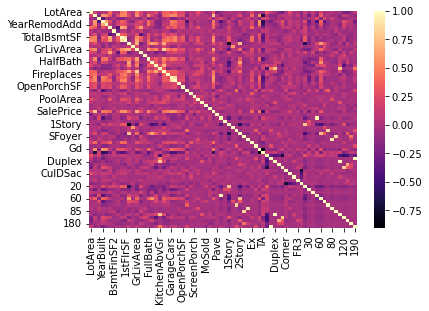

In [73]:
# # Interrogate data

import matplotlib.pyplot as plt # visualization
import seaborn as sb # visualization
from termcolor import colored as cl # text customization

sb.heatmap(test_data.corr(), cmap = 'magma')
plt.savefig('heatmap.png', format='png')
plt.show()

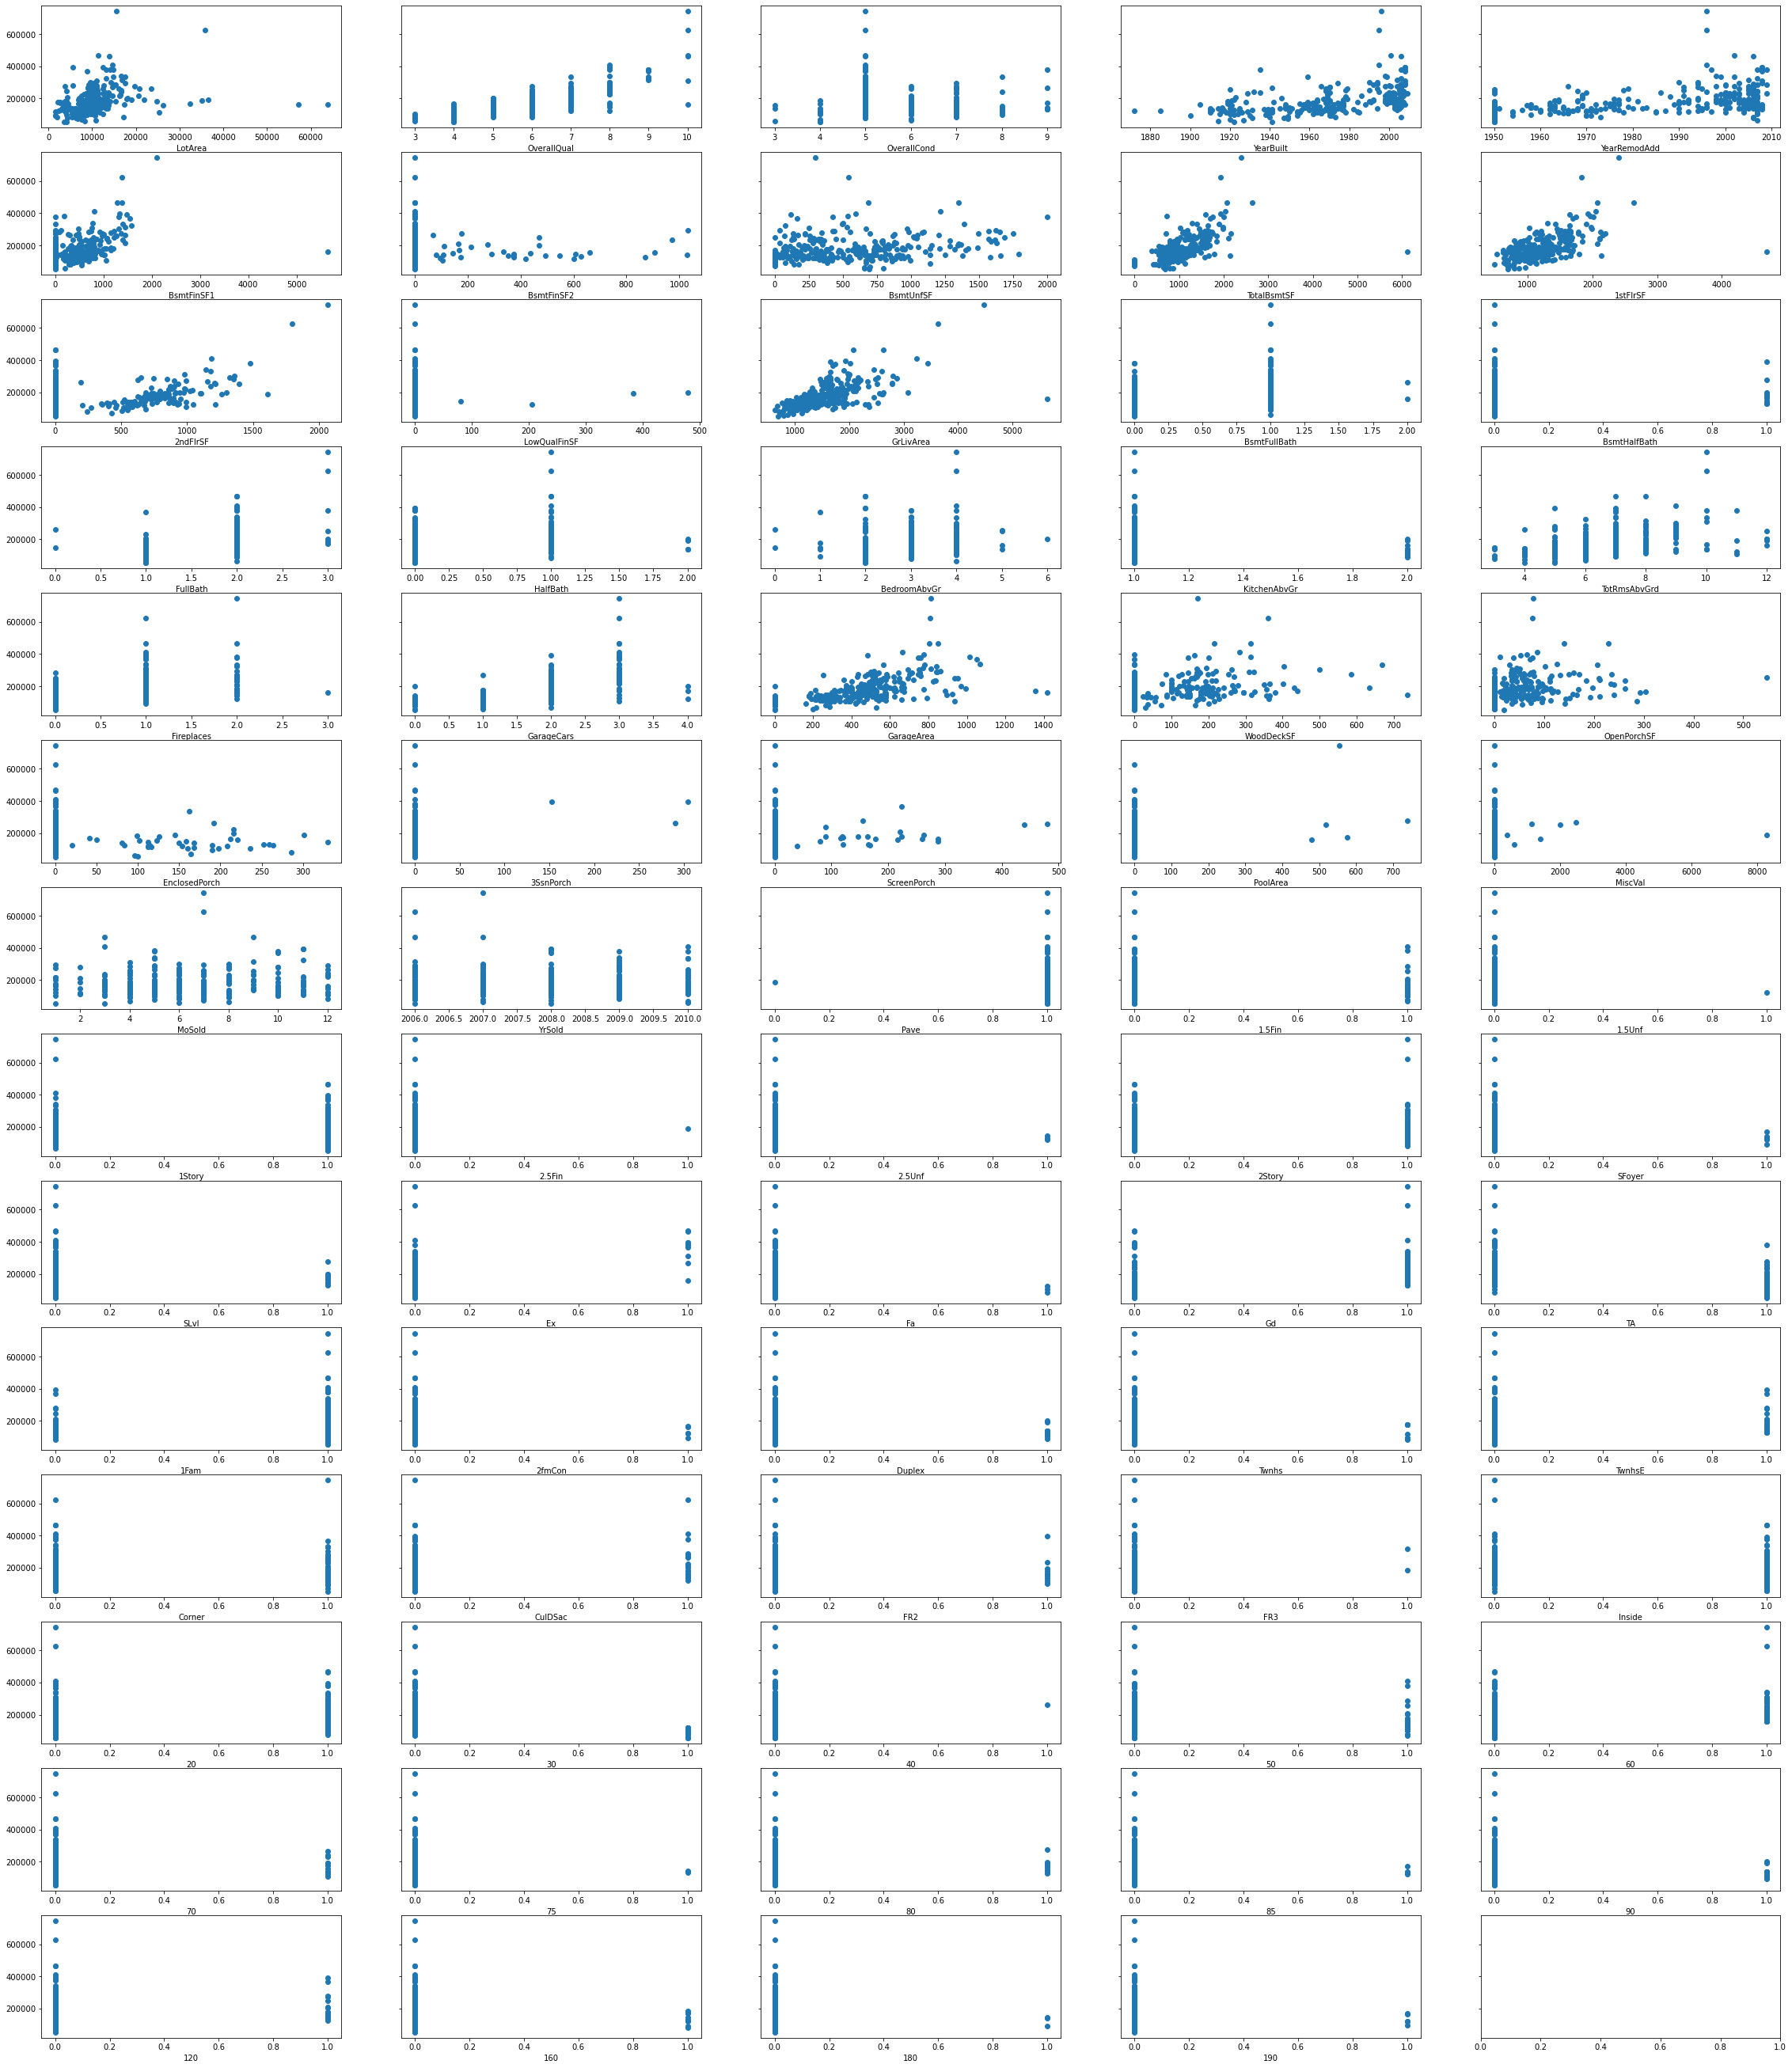

<Figure size 432x288 with 0 Axes>

In [74]:
# Plot independent variable (sales price) vs. each dependent variable
# Create subplot

import matplotlib.pyplot as plt

def plot_custom_subplot(df_obj, y_series, num_cols=int(5)):
    num_plots = len(df_obj.columns)
    num_rows = math.ceil(num_plots/num_cols)
    fig, ax_array =  plt.subplots(num_rows, num_cols, figsize=(100/2.54, 120/2.54), sharey=True)

    k = 0
    for ax_row in ax_array:
        for axes in ax_row:
            axes.set_xlabel(df_obj.columns[k])
            axes.scatter(df_obj.iloc[:, k], y_series)
            k += 1
            if k == num_plots:
                break
    
    plt.show()    
    plt.savefig('scatter.png', format='png')


# Prep plot data
scatter_df = test_data.copy()
scatter_df = scatter_df.drop('SalePrice', axis = 1)

# Main
import math
plot_custom_subplot(scatter_df, test_data['SalePrice'])

In [75]:
# Cleave the data

def cleave_label_and_features(prepared_data):
    X = prepared_data.drop(['SalePrice'], axis=1)
    y = prepared_data['SalePrice']
    return X, y

X_test, y_test = cleave_label_and_features(test_data)


In [76]:
# One data preparation function to rule them all

def prepare_data(data):
    cols_with_missing = get_cols_with_missing(data, "Missing")
    replace_missing_with_mean(data, cols_with_missing)

    categoricals = get_categoricals(data)
    data = one_hot_encode(data, categoricals + ['MSSubClass'])
    data = data.drop(['ID'], axis=1)

    convert_dtype_int(data)
    X, y = cleave_label_and_features(data)

    return X, y

In [77]:
X_train, y_train = prepare_data(train_data)

# Comment: train_data has one more MSSubClass than testData

category: Street: ['Pave' 'Grvl']
category: HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
category: ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
category: BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
category: LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
category: MSSubClass: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]


In [84]:
# Figure out what to do about X_train
set_a = { 70,  60,  80,  20, 160,  50, 120,  30, 190,  75,  85,  90,  40, 180} # from test
set_b = { 60, 20,  70, 50, 190,  45,  90, 120,  30,  85,  80, 160,  75, 180,  40} # from train

result = set_a.symmetric_difference(set_b) 
print(result) # 45

{45}


In [86]:
X_train = X_train.drop([45], axis=1)

Coefficients: 
 [ 4.97670451e-01  1.08152150e+04  4.46467921e+03  4.83654104e+02
  1.79861598e+02  1.75027776e+01  3.48376627e+00 -7.78563048e-01
  2.02079807e+01  8.47693981e+00  2.49926382e+01  4.02742368e+00
  3.74970013e+01  2.11487968e+03 -9.55368960e+02  2.17688240e+03
  2.21072854e+03 -1.05591786e+04 -2.92138536e+04  6.10409677e+03
  4.87713654e+03  3.28781119e+03  2.34775995e+01  1.62755672e+01
 -1.93241531e+01  1.61945930e+01 -1.11478816e+01  5.68620823e+01
 -6.17966875e+01 -5.90594472e-01 -3.50389026e+02 -9.62715770e+02
  4.17253868e+04 -1.30566162e+03  2.33533744e+04  1.48945303e+04
 -1.78089248e+04 -1.82334280e+04  3.71079412e+03  1.57715362e+03
 -6.18783799e+03  3.88018276e+04 -3.62109604e+02 -1.38145930e+04
 -2.46251250e+04  6.60324057e+03 -1.06342008e+04  7.15995624e+03
 -5.82845143e+03  2.69945538e+03 -3.21285698e+02  6.72813215e+03
 -3.11774645e+03 -4.71873806e+03  1.42963806e+03 -6.76960345e+02
  7.68595929e+03 -9.64696682e+02  8.91717383e+03 -8.20967464e+03
  5.15942

ValueError: x and y must be the same size

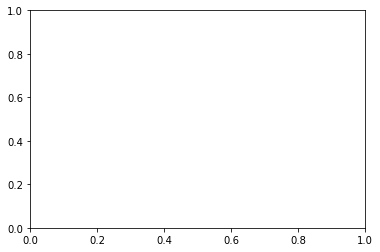

In [88]:
# Do Linear regression
# https://scikit-learn.org/stable/about.html#citing-scikit-learn

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object (Ordinary Least Squares)
reg = linear_model.LinearRegression() 

# Train the model using the training sets
reg.fit(X_train, y_train)

# Make predictions using the testing set
y_predicted = reg.predict(X_test)

# The coefficients
print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_predicted))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_predicted))


# Task 1 
Apply two techniques to handle missing data
Justify why these two techniques were chosen
compare the regression model's performance on the two data sets

TEchnique 1: drop the missing valus
technique 2: fill the missing values if you know them. No I don't
Technique 3: fill missing values with the mean of that column

# Task 2
 Write Python code to build a regression model from the training set that you applied the better
solution in (1). Write the code to evaluate its performance on the test set that you applied the better
solution in (1) with Root-Mean-Squared-Error (RMSE). RMSE shares similar motivation of the least
square loss we taught in the lecture. Section 5 gives reference for the definition. Please try at least
two regression models and compare their performances.  

# Task 3
There are 38 features provided for each house. Are all of the features used in your regression
models? What’s the impact if removing some features? Please write your own code to compare
different feature selections and justify your selection. At least two feature selections are investigated
(full feature set, a subset of the features). The dataset is the modified ones that you applied the
better solution in (1). (6 Marks)

In [ ]:
import os
current_dir = os.getcwd
print(current_dir)

<built-in function getcwd>


v